In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import pandas as pd

In [11]:
def generar_capas(n_capas: int = 128, 
                  r: float = 3.442619855899, 
                  v: float = 9.91256303526217e-3) -> np.ndarray:
    """
    Calcula los bordes x_i de las capas del ziggurat para la normal estándar (lado positivo).
    
    Implementación basada en Marsaglia & Tsang (2000), sección 3.
    
    Args:
        n_capas: Número de capas (típicamente 64, 128, o 256)
        r: Borde derecho (x_{N-1}), del paper
        v: Área común de cada rectángulo, del paper
    
    Returns:
        Array de forma (n_capas,) con los bordes:
        - x_list[0] = 0 (borde izquierdo)
        - x_list[i] = borde derecho de la capa i
        - x_list[-1] = r (borde de la cola)
    """
    # Función densidad sin normalizar, es decir, sin 1/sqrt(2*pi) (lado positivo de N(0,1))
    f = lambda x: np.exp(-0.5 * x * x)
    
    # Inversa de f: f^{-1}(y) = sqrt(-2 * ln(y))
    f_inv = lambda y: np.sqrt(-2.0 * np.log(y))
    
    # Array de bordes (x_0, x_1, ..., x_{N-1})
    x_list = np.zeros(n_capas, dtype=np.float64)
    x_list[-1] = r  # x_{N-1} = r (borde de la cola)
    
    # Iteración hacia atrás: x_i = f^{-1}(v/x_{i+1} + f(x_{i+1}))
    # Basado en la relación: x_i * [f(x_{i-1}) - f(x_i)] = v
    for i in range(n_capas - 2, 0, -1):
        y = f(x_list[i + 1]) + v / x_list[i + 1]
        x_list[i] = f_inv(y)
    
    # x_0 es el borde izquierdo (siempre 0)
    x_list[0] = 0.0
    
    return x_list

In [12]:
def generar_tablas_precalculadas(x_list: np.ndarray, v: float):
    """
    Construye las tablas k, w, f del Ziggurat para optimizar la generación.
    
    Estas tablas permiten que el test rápido (paso 2 del algoritmo) se ejecute
    con solo 2 accesos a memoria y 1 comparación de enteros.
    
    Tablas generadas:
    - k[i]: Umbral entero para el test rápido (uint32)
    - w[i]: Factor de escala para convertir entero → float (float64)
    - f[i]: Valores precalculados de la densidad f(x_i) (float64)
    
    Args:
        x_list: Array con los bordes x_i de las capas (longitud N)
        v: Área común de cada rectángulo
    
    Returns:
        (k_list, w_list, f_list): Tupla con las tres tablas
    
    Notas sobre el diseño:
    - M = 2^31 porque trabajamos con enteros int32 (rango: -2^31 a 2^31-1)
    - La capa i=0 es especial: combina rectángulo base + cola infinita
    """
    x_list = np.asarray(x_list, dtype=np.float64)
    N = x_list.size
    
    if N < 2:
        raise ValueError("Se requieren al menos 2 bordes: x_0≈0 y x_{N-1}=r.")

    # Tablas a rellenar
    f_list = np.exp(-0.5 * x_list * x_list)
    k_list = np.zeros(N, dtype=np.uint32)
    w_list = np.zeros(N, dtype=np.float64)

    # Escala entera M = 2^31 
    M = float(2**31)


    # (A) Filas i>=1: relaciones directas entre bordes adyacentes
    w_list[1:] = x_list[1:] / M
    with np.errstate(divide="ignore", invalid="ignore"):
        # Calcular ratio x_{i-1} / x_i para todas las capas
        ratio = x_list[:-1] / x_list[1:]
        # Manejar casos donde x_i podría ser 0 (solo x_0 en realidad)
        ratio = np.where(x_list[1:] > 0, ratio, 0.0)
    # Escalar a enteros y truncar: k[i] = floor(M * ratio)
    k_list[1:] = np.floor(M * ratio).astype(np.uint32)

    # (B) Fila i=0 (base + cola): usa q = v / f(r)
    r = x_list[-1]
    fr = f_list[-1]

    if fr <= 0.0:
        raise ValueError("f(r) es 0")
    
    q = v / fr
    k_list[0] = np.uint32(np.floor((r / q) * M))
    w_list[0] = q / M

    return k_list, w_list, f_list

In [13]:
def cola_normal(r: float, rng: np.random.Generator, u1_inicial: float = None) -> float:
    """
    Genera un valor de la cola derecha de N(0,1) (x > r).
    Usa el método de Marsaglia (1963) optimizado.
    
    Este método transforma la cola exponencial en el intervalo unitario
    y aplica rechazo para generar valores > r de la normal.
    
    Args:
        r: límite de la cola (típicamente r ≈ 3.44 para N=128)
        rng: generador de números aleatorios
        u1_inicial: primer uniforme
    
    Returns:
        float: valor x > r siguiendo la cola de N(0,1)
    """

    # Primera iteración: reutilizar u1_inicial si está disponible
    # Esto ahorra una llamada al RNG cuando venimos del test rápido fallido
    u1 = u1_inicial if u1_inicial is not None else rng.random()
    
    while True:
        # Generar segundo uniforme
        u2 = rng.random()

        # Transformación de Marsaglia (1963)
        x = -np.log(u1) / r
        y = -np.log(u2)
        
        # Test de aceptación de Marsaglia:
        # Aceptar si 2*y > x², equivalente a y+y > x*x
        # Esto acepta puntos bajo la curva exp(-x²/2) en la cola
        # Eficiencia: ~88% de aceptación para r=3.44
        if (y + y) > (x * x):
            return r + x
        
        # Rechazado: genera nuevo u1 para siguiente iteración
        u1 = rng.random()

In [14]:
def ziggurat_norm_one(
    rng: np.random.Generator,
    k: np.ndarray,        # uint32, shape (N,)
    w: np.ndarray,        # float64, shape (N,)
    f: np.ndarray,        # float64, shape (N,), f[i]=exp(-xi[i]^2/2)
    xi: np.ndarray,       # float64, shape (N,), bordes lado positivo
    r: float              # límite derecho (xi[-1])
) -> float:
    """
    Genera UNA muestra ~ N(0,1) usando el método Ziggurat (Marsaglia & Tsang, 2000),
    con tablas precalculadas (k, w, f, xi). Devuelve un float.

    Reglas:
      - Test rápido: |hz| < k[i]  -> x = hz * w[i] (aceptado)
      - Si i == 0 y falla: cola (x>r) con Marsaglia 1963; aplicar signo de hz
      - Si i > 0 y falla: tiras (rechazo local) con alturas tabuladas f[i-1], f[i]
    """
    
    while True:
        # 1) Genera UN solo entero de 32 bits con signo
        hz = rng.integers(np.iinfo(np.int32).min, np.iinfo(np.int32).max, 
                         dtype=np.int32, endpoint=True)
        
        # 2) Índice de capa (usa los últimos 7 bits para N=128)
        iz = abs(hz) & 127
        
        # 3) Test rápido: |hz| < k[iz] ?
        abs_hz = np.uint32(abs(int(hz)))
        if abs_hz < k[iz]:
            # Acepta inmediatamente
            return float(hz) * float(w[iz])
        
        # 4) Test falló - determinar signo una sola vez
        sign = 1.0 if hz >= 0 else -1.0
        
        # 5) Casos especiales según el índice
        if iz == 0:
            # COLA: genera valor > r usando el método de Marsaglia
            u1_inicial = abs_hz / (2.0**32)
            x_tail = cola_normal(r, rng, u1_inicial)
            return sign * x_tail
        
        else:
            # TIRAS (strips): usa hz para formar x
            # x = hz * w[iz] ya está calculado implícitamente
            x = float(hz) * float(w[iz])
            
            # Genera UN solo uniforme para el test de rechazo
            u = rng.random()
            
            # Test: f[iz-1] - f[iz] * U < f(x) - f[iz]
            # Equivalente a: [f(x_{i-1}) - f(x_i)] * U < f(x) - f(x_i)
            # (ver paso 4 del algoritmo en la página 3 del paper)
            lhs = (float(f[iz - 1]) - float(f[iz])) * u
            rhs = np.exp(-0.5 * x * x) - float(f[iz])
            
            if lhs < rhs:
                return x
            
            # Si rechaza, el while True reinicia con nuevo hz


In [15]:
def generar_muestras_ziggurat(n_muestras: int, seed: int = 42) -> np.ndarray:
    """
    Genera n_muestras usando el método Ziggurat.
    
    Args:
        n_muestras: Cantidad de números aleatorios a generar
        seed: Semilla para reproducibilidad
    
    Returns:
        Array de forma (n_muestras) con valores ~ N(0,1)
    """
    # 1. Inicializar generador
    mt = np.random.MT19937(seed=seed)
    rng = np.random.Generator(mt)
    
    # 2. Generar capas y tablas (solo una vez)
    print("Inicializando Ziggurat...")
    r = 3.442619855899
    v = 9.91256303526217e-3
    x_list = generar_capas(n_capas=128, r=r, v=v)
    k, w, f = generar_tablas_precalculadas(x_list, v)
    print(f"Tablas generadas para {len(x_list)} capas")
    
    # 3. Generar muestras
    print(f"Generando {n_muestras:,} muestras...")
    start_time = time.time()
    
    muestras = np.array([ziggurat_norm_one(rng, k, w, f, x_list, r) 
                        for _ in range(n_muestras)])
    
    elapsed = time.time() - start_time
    print(f"Generadas en {elapsed:.3f} segundos ({n_muestras/elapsed:,.0f} muestras/seg)")
    
    return muestras

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import pandas as pd

def generar_capas(n_capas: int = 128, 
                  r: float = 3.442619855899, 
                  v: float = 9.91256303526217e-3) -> np.ndarray:
    """
    Calcula los bordes x_i de las capas del ziggurat para la normal estándar (lado positivo).
    
    Implementación basada en Marsaglia & Tsang (2000), sección 3.
    
    Args:
        n_capas: Número de capas (típicamente 64, 128, o 256)
        r: Borde derecho (x_{N-1}), del paper
        v: Área común de cada rectángulo, del paper
    
    Returns:
        Array de forma (n_capas,) con los bordes:
        - x_list[0] = 0 (borde izquierdo)
        - x_list[i] = borde derecho de la capa i
        - x_list[-1] = r (borde de la cola)
    """
    # Función densidad sin normalizar, es decir, sin 1/sqrt(2*pi) (lado positivo de N(0,1))
    f = lambda x: np.exp(-0.5 * x * x)
    
    # Inversa de f: f^{-1}(y) = sqrt(-2 * ln(y))
    f_inv = lambda y: np.sqrt(-2.0 * np.log(y))
    
    # Array de bordes (x_0, x_1, ..., x_{N-1})
    x_list = np.zeros(n_capas, dtype=np.float64)
    x_list[-1] = r  # x_{N-1} = r (borde de la cola)
    
    # Iteración hacia atrás: x_i = f^{-1}(v/x_{i+1} + f(x_{i+1}))
    # Basado en la relación: x_i * [f(x_{i-1}) - f(x_i)] = v
    for i in range(n_capas - 2, 0, -1):
        y = f(x_list[i + 1]) + v / x_list[i + 1]
        x_list[i] = f_inv(y)
    
    # x_0 es el borde izquierdo (siempre 0)
    x_list[0] = 0.0
    
    return x_list


def generar_tablas_precalculadas(x_list: np.ndarray, v: float):
    """
    Construye las tablas k, w, f del Ziggurat para optimizar la generación.
    
    Estas tablas permiten que el test rápido (paso 2 del algoritmo) se ejecute
    con solo 2 accesos a memoria y 1 comparación de enteros.
    
    Tablas generadas:
    - k[i]: Umbral entero para el test rápido (uint32)
    - w[i]: Factor de escala para convertir entero → float (float64)
    - f[i]: Valores precalculados de la densidad f(x_i) (float64)
    
    Args:
        x_list: Array con los bordes x_i de las capas (longitud N)
        v: Área común de cada rectángulo
    
    Returns:
        (k_list, w_list, f_list): Tupla con las tres tablas
    
    Notas sobre el diseño:
    - M = 2^31 porque trabajamos con 31 bits de magnitud (1 bit para signo)
    - La capa i=0 es especial: combina rectángulo base + cola infinita
    """
    x_list = np.asarray(x_list, dtype=np.float64)
    N = x_list.size
    
    if N < 2:
        raise ValueError("Se requieren al menos 2 bordes: x_0≈0 y x_{N-1}=r.")

    # Tablas a rellenar
    f_list = np.exp(-0.5 * x_list * x_list)
    k_list = np.zeros(N, dtype=np.uint32)
    w_list = np.zeros(N, dtype=np.float64)

    # Escala entera M = 2^31 (magnitud de 31 bits)
    M = float(1 << 31)

    # (A) Filas i>=1: relaciones directas entre bordes adyacentes
    w_list[1:] = x_list[1:] / M
    with np.errstate(divide="ignore", invalid="ignore"):
        # Calcular ratio x_{i-1} / x_i para todas las capas
        ratio = x_list[:-1] / x_list[1:]
        # Manejar casos donde x_i podría ser 0 (solo x_0 en realidad)
        ratio = np.where(x_list[1:] > 0, ratio, 0.0)
    # Escalar a enteros y truncar: k[i] = floor(M * ratio)
    k_list[1:] = np.floor(M * ratio).astype(np.uint32)

    # (B) Fila i=0 (base + cola): usa q = v / f(r)
    r = x_list[-1]
    fr = np.exp(-0.5 * r * r)

    if fr <= 0.0:
        raise ValueError("f(r) es 0")
    
    q = v / fr
    k_list[0] = np.uint32(np.floor((r / q) * M))
    w_list[0] = q / M

    return k_list, w_list, f_list


def cola_normal(r: float, rng: np.random.Generator, u1_inicial: float = None) -> float:
    """
    Genera un valor de la cola derecha de N(0,1) (x > r).
    Usa el método de Marsaglia (1963) optimizado.
    
    Este método transforma la cola exponencial en el intervalo unitario
    y aplica rechazo para generar valores > r de la normal.
    
    Args:
        r: límite de la cola (típicamente r ≈ 3.44 para N=128)
        rng: generador de números aleatorios
        u1_inicial: primer uniforme
    
    Returns:
        float: valor x > r siguiendo la cola de N(0,1)
    """

    # Primera iteración: reutilizar u1_inicial si está disponible
    # Esto ahorra una llamada al RNG cuando venimos del test rápido fallido
    u1 = u1_inicial if u1_inicial is not None else rng.random()
    
    while True:
        # Generar segundo uniforme
        u2 = rng.random()

        # Transformación de Marsaglia (1963)
        x = -np.log(u1) / r
        y = -np.log(u2)
        
        # Test de aceptación de Marsaglia:
        # Aceptar si 2*y > x², equivalente a y+y > x*x
        # Esto acepta puntos bajo la curva exp(-x²/2) en la cola
        # Eficiencia: ~88% de aceptación para r=3.44
        if (y + y) > (x * x):
            return r + x
        
        # Rechazado: genera nuevo u1 para siguiente iteración
        u1 = rng.random()


def ziggurat_norm_one(
    rng: np.random.Generator,
    k: np.ndarray,        # uint32, shape (N,)
    w: np.ndarray,        # float64, shape (N,)
    f: np.ndarray,        # float64, shape (N,), f[i]=exp(-xi[i]^2/2)
    xi: np.ndarray,       # float64, shape (N,), bordes lado positivo
    r: float              # límite derecho (xi[-1])
) -> float:
    """
    Genera UNA muestra ~ N(0,1) usando el método Ziggurat (Marsaglia & Tsang, 2000),
    con tablas precalculadas (k, w, f, xi). Devuelve un float.
    
    Usa uint32 y operaciones bit a bit para extraer signo e índice.
    Magnitud de 31 bits (bit 31 es el signo).

    Reglas:
      - Test rápido: mag < k[i]  -> x = ±mag * w[i] (aceptado)
      - Si i == 0 y falla: cola (x>r) con Marsaglia 1963; aplicar signo
      - Si i > 0 y falla: tiras (rechazo local) con alturas tabuladas f[i-1], f[i]
    """
    
    while True:
        # 1) Un entero de 32 bits SIN signo
        u = rng.integers(0, 1 << 32, dtype=np.uint32, endpoint=False)
        
        # 2) Índice (7 bits bajos) y signo (MSB, bit 31)
        iz = int(u & np.uint32(0x7F))  # 0..127
        sign = -1.0 if (u & np.uint32(0x80000000)) else 1.0
        
        # 3) Magnitud en 31 bits completos (sin el bit de signo)
        mag = u & np.uint32(0x7FFFFFFF)  # 0..(2^31-1)
        
        # 4) Test rápido: mag < k[iz] ?
        if mag < k[iz]:
            # Acepta inmediatamente
            return sign * (float(mag) * float(w[iz]))
        
        # 5) COLA (iz == 0): genera valor > r usando el método de Marsaglia
        if iz == 0:
            # Convertir magnitude a uniforme [0,1) coherente con M = 2^31
            u1_inicial = float(mag) * (1.0 / float(1 << 31))
            x_tail = cola_normal(r, rng, u1_inicial)
            return sign * x_tail
        
        # 6) TIRAS (iz > 0): usa magnitud para formar x
        x_abs = float(mag) * float(w[iz])
        x = sign * x_abs
        
        # Genera UN solo uniforme para el test de rechazo
        u = rng.random()
        
        # Test: f[iz-1] - f[iz] * U < f(x) - f[iz]
        # Equivalente a: [f(x_{i-1}) - f(x_i)] * U < f(x) - f(x_i)
        # (ver paso 4 del algoritmo en la página 3 del paper)
        lhs = (float(f[iz - 1]) - float(f[iz])) * u
        rhs = np.exp(-0.5 * x * x) - float(f[iz])
        
        if lhs < rhs:
            return x
        
        # Si rechaza, el while True reinicia con nuevo u


def generar_muestras_ziggurat(n_muestras: int, seed: int = 42) -> np.ndarray:
    """
    Genera n_muestras usando el método Ziggurat.
    
    Args:
        n_muestras: Cantidad de números aleatorios a generar
        seed: Semilla para reproducibilidad
    
    Returns:
        Array de forma (n_muestras) con valores ~ N(0,1)
    """
    # 1. Inicializar generador
    mt = np.random.MT19937(seed=seed)
    rng = np.random.Generator(mt)
    
    # 2. Generar capas y tablas (solo una vez)
    print("Inicializando Ziggurat...")
    r = 3.442619855899
    v = 9.91256303526217e-3
    x_list = generar_capas(n_capas=128, r=r, v=v)
    k, w, f = generar_tablas_precalculadas(x_list, v)
    print(f"Tablas generadas para {len(x_list)} capas")
    
    # 3. Generar muestras
    print(f"Generando {n_muestras:,} muestras...")
    start_time = time.time()
    
    muestras = np.array([ziggurat_norm_one(rng, k, w, f, x_list, r) 
                        for _ in range(n_muestras)])
    
    elapsed = time.time() - start_time
    print(f"Generadas en {elapsed:.3f} segundos ({n_muestras/elapsed:,.0f} muestras/seg)")
    
    return muestras

In [17]:
def realizar_tests_estadisticos(muestras: np.ndarray):
    """
    Realiza tests estadísticos sobre las muestras generadas.
    
    Tests incluidos:
    - Estadísticos descriptivos básicos
    - Test t de Student para la media
    - Test Chi-cuadrado para la varianza
    - Test Kolmogorov-Smirnov para normalidad
    """
    n = len(muestras)
    print("\n" + "="*70)
    print(f"TESTS ESTADÍSTICOS (n = {n:,} muestras)")
    print("="*70)
    
    # 1. Estadísticos básicos
    media = np.mean(muestras)
    varianza = np.var(muestras, ddof=1)  # ddof=1 para varianza muestral
    desviacion = np.std(muestras, ddof=1)
    
    print(f"\n1. ESTADÍSTICOS DESCRIPTIVOS:")
    print(f"   Media:              {media:12.8f}  (esperado: 0.0)")
    print(f"   Varianza:           {varianza:12.8f}  (esperado: 1.0)")
    print(f"   Desviación estándar:{desviacion:12.8f}  (esperado: 1.0)")
    print(f"   Mínimo:             {np.min(muestras):12.8f}")
    print(f"   Máximo:             {np.max(muestras):12.8f}")
    print(f"   Asimetría:          {stats.skew(muestras):12.8f}  (esperado: ~0.0)")
    print(f"   Curtosis:           {stats.kurtosis(muestras):12.8f}  (esperado: ~0.0)")
    
    # 2. Test t de Student para la media (H₀: μ = 0)
    print(f"\n2. TEST t DE STUDENT (H₀: μ = 0):")
    print(f"   Contrasta si la media muestral es estadísticamente igual a 0.")
    t_stat, p_value_media = stats.ttest_1samp(muestras, 0.0)
    print(f"   Estadístico t:      {t_stat:12.8f}")
    print(f"   p-valor:            {p_value_media:12.8f}")
    print(f"   Interpretación:     ", end="")
    if p_value_media > 0.05:
        print(f"✓ No se rechaza H₀ (α=0.05)")
        print(f"                       La media muestral es estadísticamente igual a 0")
    else:
        print(f"✗ Se rechaza H₀ (α=0.05)")
        print(f"                       La media muestral difiere significativamente de 0")
    
    # 3. Test Chi-cuadrado para la varianza (H₀: σ² = 1)
    print(f"\n3. TEST CHI-CUADRADO (H₀: σ² = 1):")
    print(f"   Contrasta si la varianza muestral es estadísticamente igual a 1.")
    chi2_stat = (n - 1) * varianza / 1.0
    p_value_var = 2 * min(stats.chi2.cdf(chi2_stat, n-1), 
                          1 - stats.chi2.cdf(chi2_stat, n-1))
    print(f"   Estadístico χ²:     {chi2_stat:12.2f}")
    print(f"   Grados de libertad: {n-1}")
    print(f"   p-valor:            {p_value_var:12.8f}")
    print(f"   Interpretación:     ", end="")
    if p_value_var > 0.05:
        print(f"✓ No se rechaza H₀ (α=0.05)")
        print(f"                       La varianza muestral es estadísticamente igual a 1")
    else:
        print(f"✗ Se rechaza H₀ (α=0.05)")
        print(f"                       La varianza muestral difiere significativamente de 1")
    
    # 4. Test de Kolmogorov-Smirnov para normalidad (H₀: muestras ~ N(0,1))
    print(f"\n4. TEST KOLMOGOROV-SMIRNOV (H₀: muestras ~ N(0,1)):")
    print(f"   Contrasta si las muestras siguen una distribución normal estándar.")
    print(f"   Compara la función de distribución acumulada empírica con la teórica.")
    ks_stat, p_value_ks = stats.kstest(muestras, 'norm')
    print(f"   Estadístico D:      {ks_stat:12.8f}")
    print(f"   p-valor:            {p_value_ks:12.8f}")
    print(f"   Interpretación:     ", end="")
    if p_value_ks > 0.05:
        print(f"✓ No se rechaza H₀ (α=0.05)")
        print(f"                       Las muestras siguen una distribución N(0,1)")
    else:
        print(f"✗ Se rechaza H₀ (α=0.05)")
        print(f"                       Las muestras NO siguen una distribución N(0,1)")
    
    print("\n" + "="*70)
    
def visualizar_resultados(muestras: np.ndarray, guardar: bool = True):
    """
    Crea visualizaciones para validar la normalidad de las muestras.
    """
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Histograma vs densidad teórica
    ax1 = plt.subplot(2, 3, 1)
    counts, bins, _ = ax1.hist(muestras, bins=100, density=True, alpha=0.7, 
                                color='steelblue', edgecolor='black', linewidth=0.5)
    x_plot = np.linspace(-4, 4, 1000)
    ax1.plot(x_plot, stats.norm.pdf(x_plot, 0, 1), 'r-', lw=2.5, 
             label='N(0,1) teórica')
    ax1.set_xlabel('Valor', fontsize=11)
    ax1.set_ylabel('Densidad', fontsize=11)
    ax1.set_title('Histograma vs Densidad Teórica', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. Q-Q plot
    ax2 = plt.subplot(2, 3, 2)
    stats.probplot(muestras, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. CDF empírica vs teórica
    ax3 = plt.subplot(2, 3, 3)
    x_sorted = np.sort(muestras)
    y_empirica = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    ax3.plot(x_sorted, y_empirica, 'b-', lw=1.5, label='CDF empírica', alpha=0.7)
    ax3.plot(x_plot, stats.norm.cdf(x_plot, 0, 1), 'r-', lw=2, 
             label='CDF teórica N(0,1)')
    ax3.set_xlabel('Valor', fontsize=11)
    ax3.set_ylabel('Probabilidad acumulada', fontsize=11)
    ax3.set_title('CDF Empírica vs Teórica', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # 4. Serie temporal (primeras 1000 muestras)
    ax4 = plt.subplot(2, 3, 4)
    n_plot = min(1000, len(muestras))
    ax4.plot(range(n_plot), muestras[:n_plot], 'b-', lw=0.8, alpha=0.7)
    ax4.axhline(y=0, color='r', linestyle='--', lw=1.5, alpha=0.7)
    ax4.axhline(y=1, color='orange', linestyle='--', lw=1, alpha=0.5)
    ax4.axhline(y=-1, color='orange', linestyle='--', lw=1, alpha=0.5)
    ax4.set_xlabel('Índice', fontsize=11)
    ax4.set_ylabel('Valor', fontsize=11)
    ax4.set_title(f'Serie Temporal (primeras {n_plot} muestras)', 
                  fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Boxplot
    ax5 = plt.subplot(2, 3, 5)
    bp = ax5.boxplot(muestras, vert=True, patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax5.axhline(y=0, color='r', linestyle='--', lw=1.5, alpha=0.7, label='μ = 0')
    ax5.set_ylabel('Valor', fontsize=11)
    ax5.set_title('Boxplot', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.legend(fontsize=10)
    
    # 6. Estadísticos en texto
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    media = np.mean(muestras)
    varianza = np.var(muestras, ddof=1)
    desv = np.std(muestras, ddof=1)
    
    texto = f"""
    ESTADÍSTICOS PRINCIPALES
    {'='*35}
    
    Tamaño muestral:    {len(muestras):,}
    
    Media:              {media:.6f}
    Desviación estándar: {desv:.6f}
    Varianza:           {varianza:.6f}
    
    Mínimo:             {np.min(muestras):.6f}
    Q1 (25%):           {np.percentile(muestras, 25):.6f}
    Mediana (50%):      {np.percentile(muestras, 50):.6f}
    Q3 (75%):           {np.percentile(muestras, 75):.6f}
    Máximo:             {np.max(muestras):.6f}
    
    Asimetría:          {stats.skew(muestras):.6f}
    Curtosis:           {stats.kurtosis(muestras):.6f}
    """
    
    ax6.text(0.1, 0.5, texto, fontsize=10, verticalalignment='center',
             fontfamily='monospace', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    
    if guardar:
        plt.savefig('ziggurat_validacion.png', dpi=300, bbox_inches='tight')
        print(f"\n✓ Gráfico guardado como 'ziggurat_validacion.png'")
    
    plt.show()

Inicializando Ziggurat...
Tablas generadas para 128 capas
Generando 1,000,000 muestras...
Generadas en 7.512 segundos (133,122 muestras/seg)

TESTS ESTADÍSTICOS (n = 1,000,000 muestras)

1. ESTADÍSTICOS DESCRIPTIVOS:
   Media:                0.00029240  (esperado: 0.0)
   Varianza:             0.99907937  (esperado: 1.0)
   Desviación estándar:  0.99953958  (esperado: 1.0)
   Mínimo:              -3.46432981
   Máximo:               3.46447909
   Asimetría:           -0.00316694  (esperado: ~0.0)
   Curtosis:            -0.02171123  (esperado: ~0.0)

2. TEST t DE STUDENT (H₀: μ = 0):
   Contrasta si la media muestral es estadísticamente igual a 0.
   Estadístico t:        0.29253090
   p-valor:              0.76988080
   Interpretación:     ✓ No se rechaza H₀ (α=0.05)
                       La media muestral es estadísticamente igual a 0

3. TEST CHI-CUADRADO (H₀: σ² = 1):
   Contrasta si la varianza muestral es estadísticamente igual a 1.
   Estadístico χ²:        999078.37
   Grados 

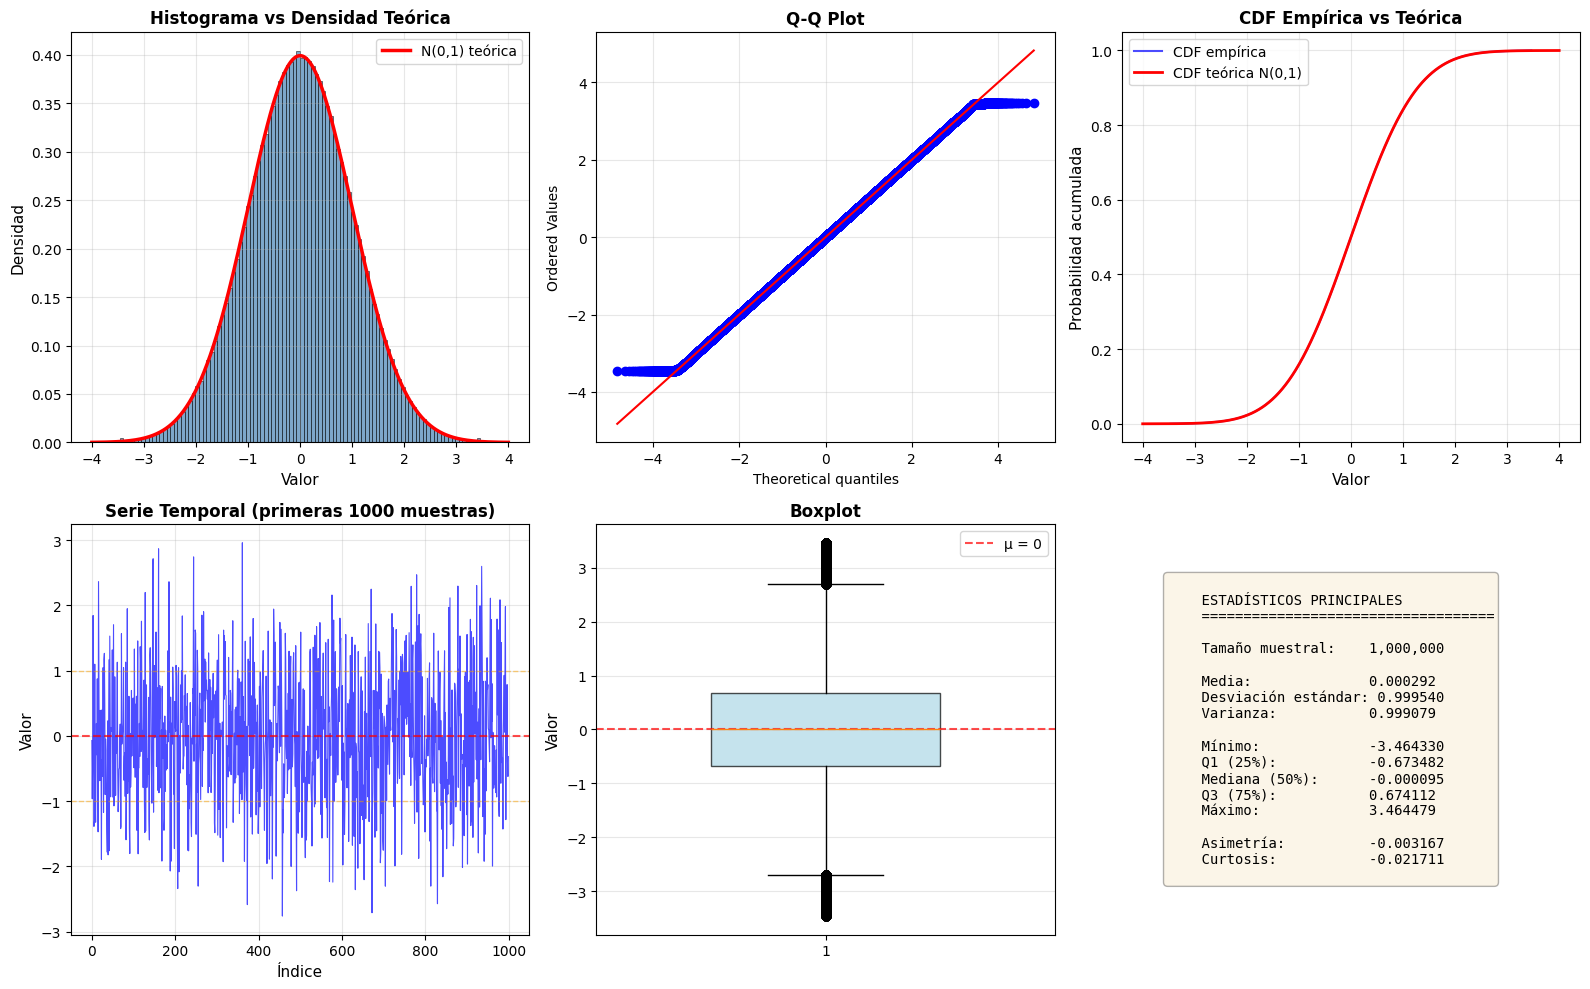

In [18]:
N_MUESTRAS = 1000000

muestras = generar_muestras_ziggurat(n_muestras=N_MUESTRAS, seed=42)
realizar_tests_estadisticos(muestras)
visualizar_resultados(muestras, guardar=True)